In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

## Define Constants

In [2]:
nu = 1 # per day
L = 1
E = 500000 # per L^2
R0 = 800/130
mu = 10 # per day
zeta = 1
beta = 1/6*(np.sqrt(2)+np.log(1+np.sqrt(2)))

mean_distance = L/8
M = 1000
ell_min = 0.01
ell_max = mean_distance*2 # For uniform Distr. it does not make sense to go further, otherwise system becomes unimodal
ell_list = np.linspace(ell_min,ell_max,M)

## Define probability distributions

In [3]:
def inverseGammaDistUnnormalized(x, d_mean=mean_distance, k=3.1):
    if (x==0):
        return 0
    elif (x>L):
        return 0
    else:
        z = x/d_mean
        return (z**(-k))*np.exp(-(k-2)/z)


def uniformDist(x):
    A = mean_distance*2
    if (x>A):
        return 0
    else:
        return 1/A
    
normalization_uniform, _ = scipy.integrate.quad(uniformDist,0,np.infty)
assert np.isclose(1, normalization_uniform), "Should already be normalized"
normalization_inverse_gamma, _ = scipy.integrate.quad(inverseGammaDistUnnormalized,0,np.infty)

print("Normalization factor for Uniform distribution: ", normalization_uniform)
print("Normalization factor for InverseGamma distribution: ", normalization_inverse_gamma)

def inverseGammaDist(x):
    return inverseGammaDistUnnormalized(x)/normalization_inverse_gamma

Normalization factor for Uniform distribution:  0.9999999999971505
Normalization factor for InverseGamma distribution:  0.10639395310187488


## Choose Probability Distribution and plot it

Integration Error:  1.3864300015768022e-08


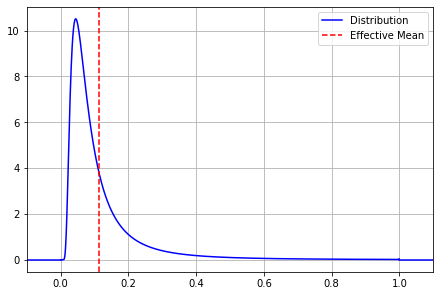

In [4]:
%matplotlib inline

# Either "uniformDist" or "inverseGammaDist"
probabilityDist = inverseGammaDist

# Function for r*p(r)
rpr = lambda r : r*probabilityDist(r)

# Calculating Effective mean (resulting from cutting off Prob. Distr. at L)
effective_mean, error = scipy.integrate.quad(rpr, 0, np.infty)
print("Integration Error: ", error)

fig, ax = plt.subplots(constrained_layout=True)

x = np.linspace(0.001,L,1000)
probabilities = np.vectorize(probabilityDist)(x)
ax.plot(x, probabilities, label='Distribution', c='b')
ax.plot([-0.1,0,x[0]], [0,0,probabilities[0]], c='b')
ax.plot([x[-1],L,L+0.1], [probabilities[-1],0,0], c='b')
ax.axvline(effective_mean, ls='--', c='r', label='Effective Mean')
ax.grid()
ax.set_xlim(-0.1,L+0.1)
ax.legend()

plt.show()

In [5]:
print("Mean: ", mean_distance)
print("Effective Mean: ", effective_mean)

Mean:  0.125
Effective Mean:  0.11318602853509298


## Calculate Carbon Footprint

In [6]:
def delta_av_theory(delta_max, b, mode='mft'):
    delta_max = 1.5
    delta_bar = 2 * delta_max / 3 + 1 / (3 * delta_max)
    if mode=='mft':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((2*b - 1)))
    elif mode=='bimodal_test':
        return np.exp(np.log(delta_bar) / np.log(2) * np.log((b + 1) / 2))

    
def cummulative_prob(x):
    return scipy.integrate.quad(probabilityDist,0,x)[0]


def size(x,dx):
    return probabilityDist(x)*np.arccos(dx/x)/(2*np.pi)


def getCarbonIndex(ell, f, b, delta, R0, mu):
    dcar = nu*E*L*L*scipy.integrate.quad(rpr,0,np.infty)[0]
    dbus = (scipy.integrate.quad(rpr,0,zeta*ell)[0] + 2*beta*ell*(1-cummulative_prob(zeta*ell)))*nu*E*L*L
    dtramr0 = 4*R0*mu*L*np.ceil(L/ell)
    
    Ci_drt = ((delta/b)*f)*dbus/dcar
    Ci_car = (1-f)*scipy.integrate.quad(rpr,0,np.infty)[0]*nu*E*L*L/dcar
    Ci_pt = dtramr0/dcar
    Ci = Ci_drt + Ci_pt + Ci_car
        
    return Ci, Ci_pt, Ci_drt, Ci_car, dcar


getCarbonIndexVectorized = np.vectorize(getCarbonIndex)


delta_av_theory = delta_av_theory(1.5, 2, mode='mft')

f = 1
av_drt_occs_non_standing = 2

Ci_theory, Ci_theory_pt, Ci_theory_drt, Ci_theory_car, _= \
    getCarbonIndexVectorized(ell_list, f, av_drt_occs_non_standing, delta_av_theory, R0, mu)

## Plot carbon footprint

<IPython.core.display.Javascript object>


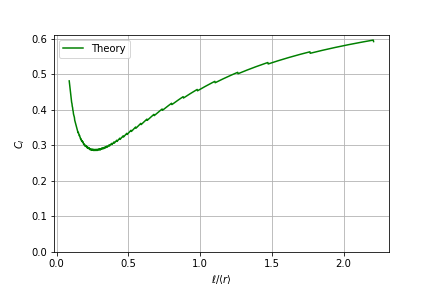

In [7]:
%matplotlib notebook

fig, ax = plt.subplots()
x_rescaled = ell_list/effective_mean
xlabel = r"$\ell/\langle r\rangle$"

ax.plot(x_rescaled, Ci_theory, "-", c='green', label="Theory")
ax.set_ylabel(r"$C_I$")

ax.set_xlabel(xlabel)
ax.legend()
ax.grid()

ax.set_ylim((0,None))

plt.show()

<IPython.core.display.Javascript object>


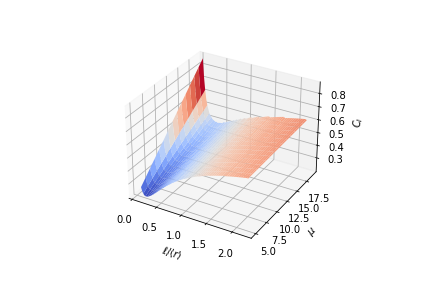

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ELL, MU = np.meshgrid(np.linspace(ell_min,ell_max,100), np.arange(5,20))

CI_THEORY, _, _, _, _ = \
    getCarbonIndexVectorized(ELL, f, av_drt_occs_non_standing, delta_av_theory, R0, MU)

ax.plot_surface(ELL/effective_mean, MU, CI_THEORY, cmap='coolwarm')
ax.set_xlabel(r'$\ell/\langle r\rangle$')
ax.set_ylabel(r'$\mu$')
ax.set_zlabel(r'$C_I$')

plt.show()

---
- For a high request frequency ($\nu E L^2$) and low $\ell$ the carbon index goes to zero
    - For given request frequency - what is a good tradeoff btw. convenience (increasing $\mu$) and emissions (decreasing $\mu$)?